# **<span style = 'color:crimson'>Generator</span>**






In [2]:
import pyvisa as visa         # PyVISA module, for GPIB comms
import numpy as np            # enable NumPy numerical analysis
import time                   # to allow pause between measurements
import os                     # Filesystem manipulation - mkdir, paths etc.
 
import matplotlib.pyplot as plt # for python-style plottting, like 'ax1.plot(x,y)'


/var/folders/lc/r3918y9n5y3gb6855vy5yq340000gn/T/ipykernel_2508/474369202.py:113: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()  # draw & show the plot - unfortunately it often opens underneath other windows


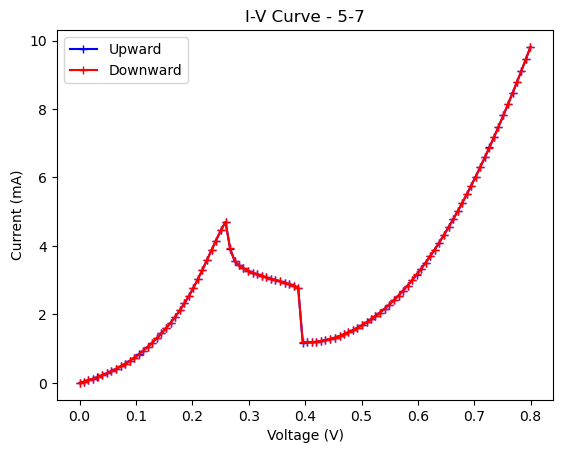

In [46]:

# -*- coding: utf-8 -*-
"""
Keithley I-V Sweep
 
Note by Bejoys: The script has been changed a bit to match the current version of Pyvisa
 
Source file is here: https://github.com/demisjohn/Keithley-I-V-Sweep/blob/master/Keithley%20I-V%20Sweep%20v2.py
"""
 
SaveFiles = True   # Save the plot & data?  Only display if False.
 
DevName = 'Data/Glasgow/BlockA/5-7'                # Filename of saved plot
folder_name = os.path.basename(DevName)
Keithley_GPIB_Addr = 22
 
CurrentCompliance = 0.01                                    # compliance (max) current
start = 0                                                   # starting value of Voltage sweep
stop = .8                                                  # ending value
numpoints = 100                                              # number of points in sweep
Downward_sweep= True                                         # If we want it to start a reverse sweep without reseting

# Open Visa connections to instruments
#keithley = visa.GpibInstrument(22)     # GPIB addr 22
rm = visa.ResourceManager()
#keithley = rm.open_resource('GPIB::'+ str(Keithley_GPIB_Addr))
keithley = rm.open_resource('USB0::0x05E6::0x2280::4393711::INSTR')#--- USB connection Keithley 1 -SOURCE METER 2018
#keithley = rm.open_resource('USB0::0x05E6::0x2280::4593849::INSTR')#--- USB connection Keithley 2 - CHIPAI 2023
 
#(To find Device connection code use NI Max software)z 
 
# Setup electrodes as voltage source
keithley.write("*RST")
#print("reset the instrument")
time.sleep(0.5)    # add second between
keithley.write(":SOUR:FUNC:MODE VOLT")
keithley.write(":SENS:CURR:PROT:LEV " + str(CurrentCompliance))
keithley.write(":SENS:CURR:RANGE:AUTO 1")   # set current reading range to auto (boolean)
keithley.write(":OUTP ON")                    # Output on    
 
upward_points = np.linspace(start, stop, num=numpoints, endpoint=True)      # voltage points that will be evaluated 
if Downward_sweep:
    # This will go from the same final value back down to the start.
    # [1:] slices off the first point to avoid duplicating `stop`.
    downward_points = np.linspace(stop, start, num=numpoints, endpoint=True)[1:]
    sweep_points = np.concatenate((upward_points, downward_points))
else:
    sweep_points = upward_points
    
# Loop to sweep voltage
Voltage = []
Current = []

for V in sweep_points:
    
    #print("Voltage set to: " + str(V) +  "V"  )
    keithley.write(":SOUR:VOLT " + str(V)+  "V"  )
    time.sleep(0.0001)                         # add second between

    data = keithley.query(":READ?")         # returns string with many values (V, I, ...)
    answer = data.split(',')                # remove delimiters, return values into list elements
    
    I = eval( answer.pop(0).replace('A', '') )*1E3     # convert to number
    Current.append( I )
    
    vread = eval( answer.pop(0).replace('V', '') )
    Voltage.append(vread)
    
    #print("--> Current = " + str(Current[-1]) + ' mA')   # print last read value


keithley.write(":OUTP OFF")     # turn off
 
#set to current source, voltage meas
keithley.write(":SOUR:FUNC:MODE curr")
keithley.write(":SOUR:CURR " + str(CurrentCompliance))
keithley.write(":SENS:volt:PROT:LEV " + str(max(Voltage))  )
keithley.write(":SENS:volt:RANGE:AUTO 1")
 
keithley.write("SYSTEM:KEY 23") # go to local control
keithley.close()
   
 
##### Divide Files #####

if Downward_sweep:
    
    Voltage_forward = Voltage[:numpoints]
    Current_forward = Current[:numpoints]
    Voltage_reverse = Voltage[numpoints-1:]
    Current_reverse = Current[numpoints-1:] 
else:
    
    Voltage_forward = Voltage
    Current_forward = Current
 

###### Plot #####
   
fig1, ax1 = plt.subplots(nrows=1, ncols=1)         # new figure & axis
 
#line1 = ax1.plot(Voltage, np.array(Voltage)/np.array(Current), 'b+-')
line1 = ax1.plot(Voltage_forward, Current_forward, 'b+-', label = 'Upward')

if Downward_sweep: 
    
    line2 = ax1.plot(Voltage_reverse, Current_reverse, 'r+-', label = 'Downward')

ax1.set_xlabel('Voltage (V)')
ax1.set_ylabel('Current (mA)')
 
ax1.set_title('I-V Curve - ' + folder_name)
ax1.legend()
fig1.show()  # draw & show the plot - unfortunately it often opens underneath other windows
 
if SaveFiles:
    # Create folder and subfolders if needed
    os.makedirs(DevName, exist_ok=True)

    curtime = time.strftime('%Y-%m-%d_%H%M.%S')
    folder_name = os.path.basename(DevName)
    SavePath = os.path.join(DevName, f'I-V Curve - {folder_name} - [{curtime}]')

    fig1.savefig(SavePath + '.png')

    data = np.stack([Voltage_forward, Current_forward], axis=1)
    np.savetxt(SavePath + 'upward_sweep.txt', data, delimiter="\t", header="Voltage(V) \t Current(mA)", comments='')

    if Downward_sweep:
        data = np.stack([Voltage_reverse, Current_reverse], axis=1)
        np.savetxt(SavePath + 'downward_sweep.txt', data, delimiter="\t", header="Voltage(V) \t Current(mA)", comments='')
